## Mapping random effects obtained from lme4

This notebook shows how to map the random effects using the outputs in R.



In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
size=4

In [31]:
def plot_1(b,title='',vmin=None,vmax=None):
    plt.imshow(b.reshape(size,size),cmap=plt.cm.get_cmap('RdBu_r',5),vmin=vmin,vmax=vmax)
    plt.title(title)
    plt.colorbar()
    
def plot_s(b,sub_title=['','','',''],vmin=None,vmax=None, cmap=plt.cm.get_cmap('viridis',21)):
    k = len(b)
    fig, axs = plt.subplots(1, k,figsize=(6*k,4))
    for i in range(k):

        ax = axs[i].imshow(b[i].reshape(size,size),cmap,vmin=vmin,vmax=vmax)
        axs[i].set_title(sub_title[i],fontsize=16)
        fig.colorbar(ax, ax=axs[i])
        
        axs[i].set_xticks(np.arange(-0.51, size-0.01, 1))
        axs[i].set_yticks(np.arange(-0.51, size-0.01, 1))
        
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
        axs[i].tick_params(axis='x', colors=(0,0,0,0))
        axs[i].tick_params(axis='y', colors=(0,0,0,0))
        
        axs[i].grid(color='black', linewidth=0.5)
        
    plt.tight_layout()
    #fig.suptitle(title, fontsize=16)

In [4]:
mlm_resid = pd.read_csv("full_res.csv").values
mlm_resid_s = pd.read_csv("full_res_s.csv").values

In [9]:
gdf = gpd.read_file("../grid_40_40.geojson")
from libpysal.weights import Queen
import spreg

In [12]:
%%time
w_res = Queen.from_dataframe(gdf)
w_res.transform = 'R'

from esda.moran import Moran

mlm_mi = []
mlm_mi_s = []
for j in range(1000):
    mlm_mi.append(Moran(mlm_resid[:,j],  w_res).I)
    mlm_mi_s.append(Moran(mlm_resid_s[:,j],  w_res).I)

CPU times: user 2min 6s, sys: 1.11 s, total: 2min 7s
Wall time: 2min 9s


In [13]:
print("MLM 4X4 Moran's I:", np.mean(mlm_mi))
print("MLM 8X8 Moran's I:", np.mean(mlm_mi_s))

MLM 4X4 Moran's I: 0.29109940743115637
MLM 8X8 Moran's I: 0.06296328920832697


In [14]:
def plot_2s(b,sub_title=['','','',''],vmin=None,vmax=None):
    size=40
    k = len(b)
    fig, axs = plt.subplots(1, k,figsize=(6*k,4))
    for i in range(k):
        if i == 0:
            ax = axs[i].imshow(b[i].reshape(size,size),
                               cmap=plt.cm.get_cmap('viridis',21),vmin=vmin,vmax=vmax)
        else:
            ax = axs[i].imshow(b[i].reshape(size,size),cmap=plt.cm.get_cmap('viridis',21),vmin=vmin,vmax=vmax)
        axs[i].set_title(sub_title[i],fontsize=16)
        fig.colorbar(ax, ax=axs[i])

        axs[i].set_xticks(np.arange(-0.5, 40, 5))
        axs[i].set_yticks(np.arange(-0.5, 40, 5))
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
        axs[i].tick_params(axis='x', colors=(0,0,0,0))
        axs[i].tick_params(axis='y', colors=(0,0,0,0))

In [28]:
mgwr_resid = pd.read_csv("../mgwr_res.csv")['mgwr_res'].values.reshape(-1,1)
sem_q_res = pd.read_csv("../sem_q_res.csv")['sem_q_res'].values.reshape(-1,1)
sem_knn_res = pd.read_csv("../sem_knn_res.csv")['sem_knn_res'].values.reshape(-1,1)

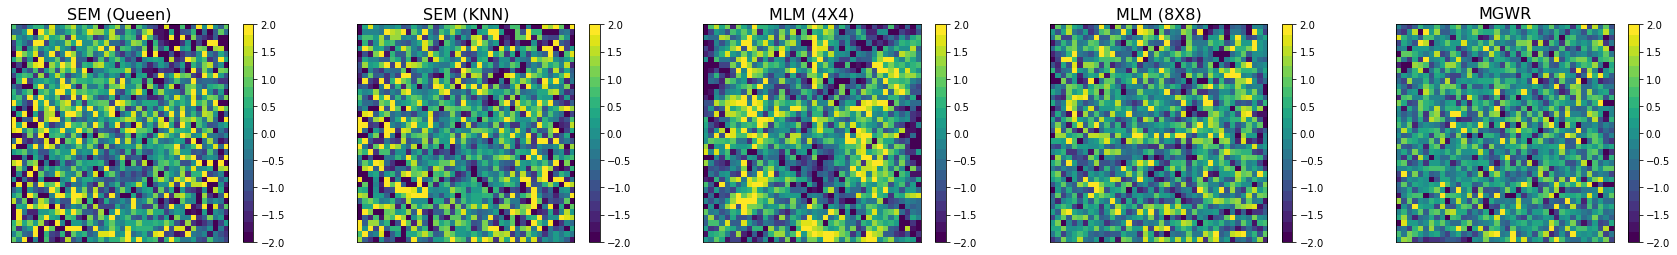

In [33]:
plot_2s([sem_q_res,sem_knn_res,np.array(mlm_resid)[:,0], np.array(mlm_resid_s)[:,0],mgwr_resid],['SEM (Queen)','SEM (KNN)',
                                                                'MLM (4X4)','MLM (8X8)','MGWR'],vmin=-2,vmax=2)
plt.savefig('../MLM res.png',dpi=300)

In [18]:
mlm_rslt = pd.DataFrame(np.array(mlm_mi).reshape(-1,1),columns=['mlm_4_res'])
mlm_rslt['mlm_8_res'] = mlm_mi_s

In [19]:
mlm_rslt.to_csv("mlm_res_mc_results.csv")